In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

C:\Users\jfcre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load and convert the data to python3 type

In [2]:
# Columns: Run, E_proton, E_iron, Zen, Q400, MuonVEM, nMuon, Type
# Note that right now, nMuon is useless
data = np.load('./data/NN_data_400m.npy')

# convert the python 2 bytes into python 3 format
data_ = []
for i in range(len(data)):
    data_.append([])
    for j in range(0,7):
        data_[i].append(float(data[i,j]))
    if data[i,7] == b'PPlus':
        data_[i].append(1)
    else:
        data_[i].append(2)
    #data_[i].append(str(data[i,7],'utf-8'))
data = np.array(data_)

Select data with $\ log(E) \in (16.0,16.5)\ $  and  $\ cos(zenith) > 0.9$

In [3]:
data_ = []
for shower in data:
    E_proton = shower[1]
    E_iron = shower[2]
    E_avg = np.sqrt(E_proton*E_iron) # geometric mean
    logE = np.log10(E_avg)
    zen = shower[3]
    if logE >= 16 and logE <= 16.5 and np.cos(zen) > 0.9:
        data_.append(shower)
data_trimmed = np.array(data_)

Split data into input (X) and output (Y)

In [4]:
X = data_trimmed[:,1:-3]
Y = data_trimmed[:,-3]

Define neural-network model to be used in the cross-validation

In [5]:
def model_base():
    # create model
    model = Sequential()
    model.add(Dense(4,input_dim=4,kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,kernel_initializer='normal'))
    # compile model
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

The next block does several things:

1. Sets a random seed 
2. Creates a pipeline that allows the data to be rescaled within each fold
3. Performs k-fold cross-validation on the neural network model

The output is the mean of the mean square error for the k folds, with the standard deviation in parentheses

In [6]:
seed = 11
np.random.seed(seed)

# The Pipeline - 1. rescale data, 2. wrapper for sklearn
scaler = ('rescale',StandardScaler())
estimator = ('mlp',KerasRegressor(build_fn=model_base,epochs=50,batch_size=5,verbose=0))
pipeline = Pipeline([scaler,estimator])

# evaluate the model with kfold cross-validation
n_splits = 17 # data set has len = 1462. 17 is a divisor close to 10
kfold = KFold(n_splits=n_splits,random_state=seed)

results = cross_val_score(pipeline,X,Y,cv=kfold)
print("Results: %.2f (%.2f) MSE" % (-1*results.mean(), results.std()))

KeyboardInterrupt: 

Now I will grid search for different epochs and batch sizes to determine the optimum. (Note: This uses the pipeline and kfold defined in the previous cell)

NOTE: This takes too long, so I am not going to grid search or random search right now. In principle this should be done to find the best hyperparameters. Instead I am going to make individual NN's like are seen in the neural_network.ipynb notebook. Ultimately, I will perform cross validation at the end to make sure the network works well. But ideally the process in the cell below should be used to tune the network.

In [ ]:
seed = 11
np.random.seed(seed)

# The Pipeline - 1. rescale data, 2. wrapper for sklearn
scaler = ('rescale',StandardScaler())
estimator = ('mlp',KerasRegressor(build_fn=model_base,verbose=0))
pipeline = Pipeline([scaler,estimator])

# evaluate the model with kfold cross-validation
n_splits = 2 # data set has len = 1462. 17 is a divisor close to 10
kfold = KFold(n_splits=n_splits,random_state=seed)

# define the grid search parameters
batch_size = [10, 40, 80]
epochs = [50, 100,150]#,200,250]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring='mean_squared_error',cv=kfold,n_jobs=-1)
grid_result = grid.fit(X, Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Manual searching for best parameters

In [9]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
# split the data into test and training set
x_train, x_test, y_train, y_test = train_test_split(X,Y)

In [7]:
# normalize the data because the network will be sensitive
# to relative magnitudes
scaler = StandardScaler()
scaler.fit(x_train)

# apply the scaler to the sets
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

### Batch size (best ~ 10)

MSE: 14.082 (0.187)  change: -0.522


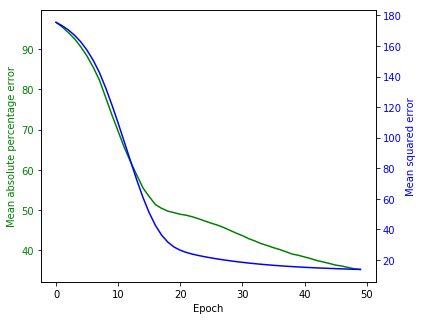

In [38]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 50
batch_size = 50

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

# print out the mse of the last 10% of epochs
look_back = -int(batch_size*0.1)
look_back = history.history['loss'][look_back:]
print(r'MSE: {0:.3f} ({1:.3f})  change: {2:.3f}'.format(np.mean(look_back),np.std(look_back),look_back[-1]-look_back[0]))

# plot the metrics vs epoch number

fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(history.history['mean_absolute_percentage_error'],color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean absolute percentage error',color='green')
ax.tick_params(axis='y', labelcolor='green')

ax_ = ax.twinx()
ax_.plot(history.history['mean_squared_error'],color='blue')
ax_.set_ylabel('Mean squared error',color='blue')
ax_.tick_params(axis='y', labelcolor='blue')
plt.show()

MSE: 11.047 (0.000)  change: 0.000


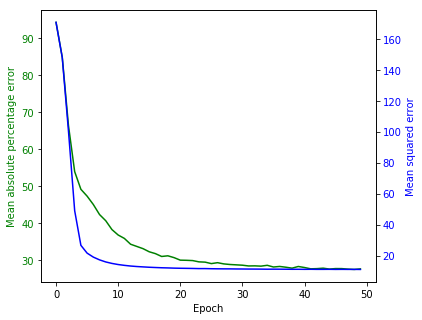

In [39]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 50
batch_size = 10

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

# print out the mse of the last 10% of epochs
look_back = -int(batch_size*0.1)
look_back = history.history['loss'][look_back:]
print(r'MSE: {0:.3f} ({1:.3f})  change: {2:.3f}'.format(np.mean(look_back),np.std(look_back),look_back[-1]-look_back[0]))

# plot the metrics vs epoch number

fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(history.history['mean_absolute_percentage_error'],color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean absolute percentage error',color='green')
ax.tick_params(axis='y', labelcolor='green')

ax_ = ax.twinx()
ax_.plot(history.history['mean_squared_error'],color='blue')
ax_.set_ylabel('Mean squared error',color='blue')
ax_.tick_params(axis='y', labelcolor='blue')
plt.show()

MSE: 12.214 (0.051)  change: -0.125


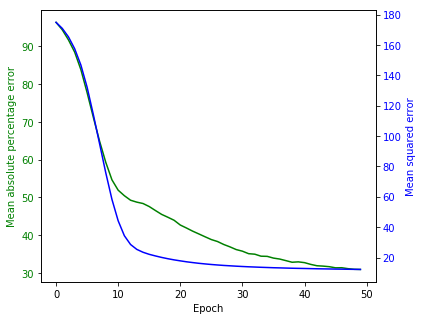

In [45]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 50
batch_size = 32

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

# print out the mse of the last 10% of epochs
look_back = -int(batch_size*0.1)
look_back = history.history['loss'][look_back:]
print(r'MSE: {0:.3f} ({1:.3f})  change: {2:.3f}'.format(np.mean(look_back),np.std(look_back),look_back[-1]-look_back[0]))

# plot the metrics vs epoch number

fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(history.history['mean_absolute_percentage_error'],color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean absolute percentage error',color='green')
ax.tick_params(axis='y', labelcolor='green')

ax_ = ax.twinx()
ax_.plot(history.history['mean_squared_error'],color='blue')
ax_.set_ylabel('Mean squared error',color='blue')
ax_.tick_params(axis='y', labelcolor='blue')
plt.show()

### Topology